In [66]:
# Imports
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [67]:
# Read in the training data set
df = pd.read_csv('data/train.csv', sep=',',keep_default_na=False, na_values='null')
# Display shape of the data
print(df.shape)
print(df)

(13288920, 13)
                id           valid_time  latitude  longitude            tp  \
0                1  2018-01-01 00:00:00      59.0      -8.00  3.814697e-06   
1                2  2018-01-01 00:00:00      59.0      -7.75  1.668930e-05   
2                3  2018-01-01 00:00:00      59.0      -7.50  1.811981e-05   
3                4  2018-01-01 00:00:00      59.0      -7.25  1.907349e-05   
4                5  2018-01-01 00:00:00      59.0      -7.00  1.525879e-05   
...            ...                  ...       ...        ...           ...   
13288915  13288916  2018-12-31 23:00:00      50.0       1.00  1.239777e-05   
13288916  13288917  2018-12-31 23:00:00      50.0       1.25  1.621246e-05   
13288917  13288918  2018-12-31 23:00:00      50.0       1.50  3.814697e-06   
13288918  13288919  2018-12-31 23:00:00      50.0       1.75  1.907349e-06   
13288919  13288920  2018-12-31 23:00:00      50.0       2.00  9.536743e-07   

               u10       v10          sp      u1

In [68]:
X_train = df.drop(columns=['t2m'])  # Features
y_train = df['t2m']  # Labels (y will be a temperature in K)

# Data Exploration

In [69]:
explore_df = df.copy(deep=True)

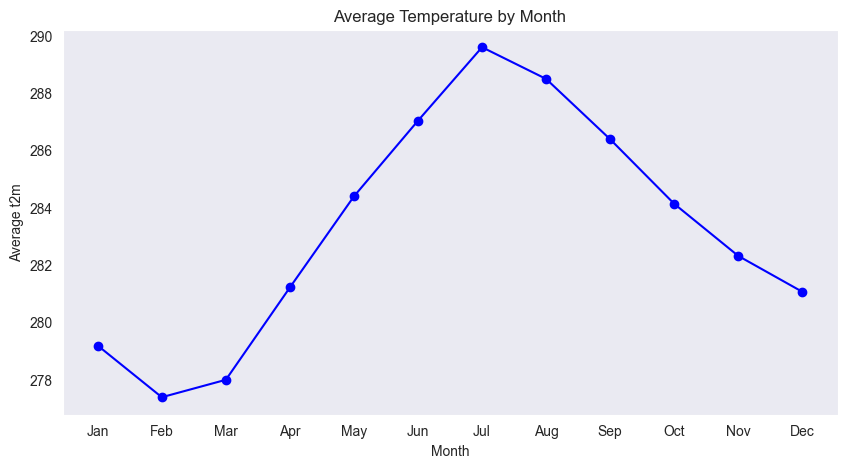

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'valid_time' to datetime format
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])

# Extract month and calculate the average t2m
explore_df['month'] = explore_df['valid_time'].dt.month
monthly_avg_temp = explore_df.groupby('month')['t2m'].mean()

# Plot the monthly average t2m
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_temp.index, monthly_avg_temp.values, marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()

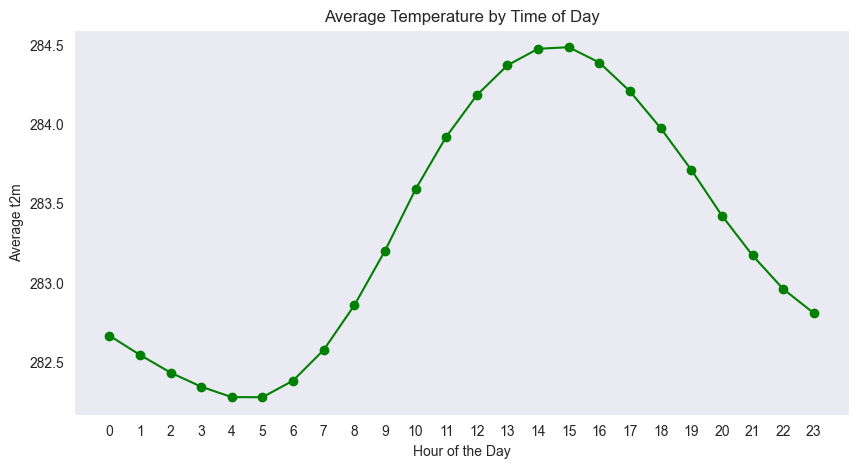

In [71]:
explore_df['valid_time'] = pd.to_datetime(explore_df['valid_time'])
explore_df['hour'] = explore_df['valid_time'].dt.hour
hourly_avg_temp = explore_df.groupby('hour')['t2m'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg_temp.index, hourly_avg_temp.values, marker='o', linestyle='-', color='g')
plt.xlabel('Hour of the Day')
plt.ylabel('Average t2m')
plt.title('Average Temperature by Time of Day')
plt.xticks(range(0, 24))  # Show every hour on x-axis
plt.grid()
plt.show()

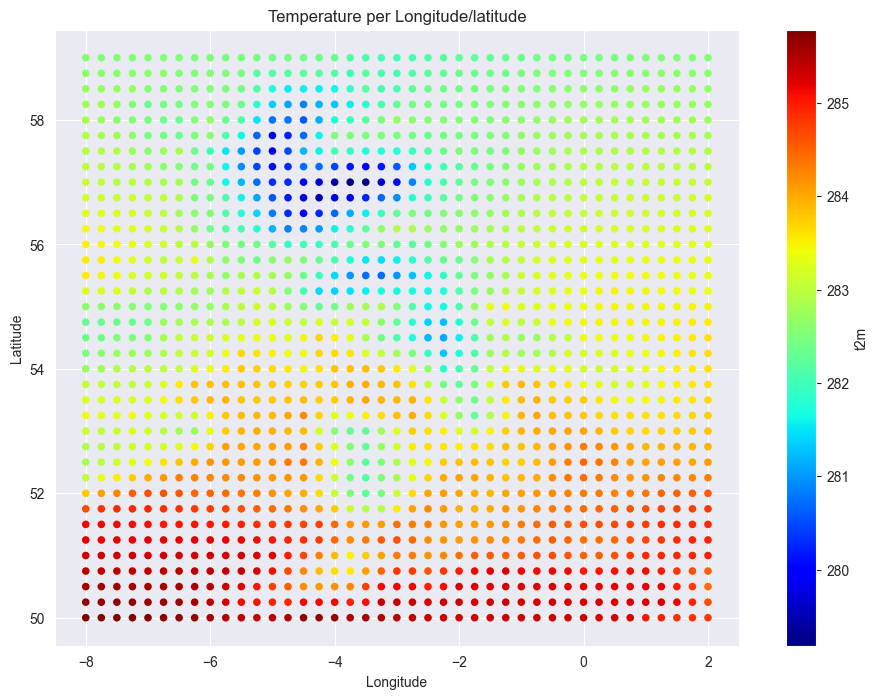

In [72]:
df_max = explore_df.groupby(['longitude', 'latitude'], as_index=False)['t2m'].mean()

# Scatter plot using longitude and latitude as coordinates
map = df_max.plot.scatter(
    x='longitude',
    y='latitude',
    c='t2m',
    cmap='jet',
    colorbar=True,
    figsize=(12, 8),
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Temperature per Longitude/latitude")
map.set_aspect('equal')
plt.show()

# Data Wrangling

In [73]:
def split_times(data):
    data['valid_time'] = pd.to_datetime(data['valid_time'])
    data['hour'] = data['valid_time'].dt.hour
    data['month'] = data['valid_time'].dt.month
    data['day'] = data['valid_time'].dt.day
    return data

In [74]:
def encode_time(data):
    # Encode 'hour' as cyclical
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

    # Encode 'month' as cyclical
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    return data

In [75]:
def encode_wind(data):
    # Wind direction (in degrees), where 0 = north, 90 = east, etc.
    data['wind10_dir'] = (np.arctan2(data['u10'], data['v10']) * (180 / np.pi)) % 360
    data['wind100_dir'] = (np.arctan2(data['u100'], data['v100']) * (180 / np.pi)) % 360

    # Convert to radians for sine/cosine encoding
    data['wind10_dir_rad'] = np.radians(data['wind10_dir'])

    # Sine and cosine components
    data['wind10_dir_sin'] = np.sin(data['wind10_dir_rad'])
    data['wind10_dir_cos'] = np.cos(data['wind10_dir_rad'])

    # Repeat for 100m wind in case it's useful
    data['wind100_dir_rad'] = np.radians(data['wind100_dir'])
    data['wind100_dir_sin'] = np.sin(data['wind100_dir_rad'])
    data['wind100_dir_cos'] = np.cos(data['wind100_dir_rad'])

    # Check the dataset
    data[['u10', 'v10', 'wind10_dir', 'wind10_dir_sin', 'wind10_dir_cos', 'wind100_dir']].sample(10)
    return data

In [76]:
def nearby_data(data, window = 3):
    features = ["wind100_dir_cos", "wind100_dir_sin", "wind10_dir_cos", "wind10_dir_sin"] # Need to change to be the correct features (dont know what the new wind ones will be called)
    for feature in features:
        data[feature + '_nearby'] = (
            data.groupby(['month', 'day', 'longitude', 'latitude'])[feature]
            .transform(lambda x: x.rolling(window=window, center=True, min_periods=1).mean())
        )
    return data.reset_index()

In [77]:
def redistribute_tp(data):
    data['tp_sqrt'] = np.sqrt(data['tp'])
    return data


In [78]:
def simplify_ptype(ptype):
    if ptype == 0:
        return 'none'
    elif ptype == 1:
        return 'rain'
    else:
        return 'other'


def encode_ptype(data):
    # Apply grouping
    data['ptype_grouped'] = data['ptype'].apply(simplify_ptype)
    return data

In [79]:
def split_month(data):
     # First let's create the half months cat
    month_section_vals = []
    dates = data["valid_time"].dt.day
    for day in dates:
        if day < 15:
            month_section_vals.append(1)
        else:
            month_section_vals.append(2)

    data["Month_half"] = month_section_vals
    return data

In [80]:
def pca_wind(data):
    #Now let's collapse the x_10 and x_100 data columns
    u_data_iso = data[["u10", "u100"]]
    pca_fit_pipe = PCA(n_components= 1)
    PCA_u_trans = pd.DataFrame(pca_fit_pipe.fit_transform(u_data_iso))
    v_data_iso = data[["v10", "v100"]]
    PCA_v_trans = pd.DataFrame(pca_fit_pipe.fit_transform(v_data_iso))


    #data = pd.concat([data, PCA_u_trans], axis = 1)    #Condensed u and v columns
    data["u_pca"] = PCA_u_trans
    data["v_pca"] = PCA_v_trans

    return data

In [81]:
def feature_selection(data):
    return data.drop(columns=['id', 'valid_time', 'day', 'ptype', 'tp', "u10", "v10", "v100", "u100", "index", "hour", "month", "wind10_dir_rad", "wind100_dir_rad"])

In [82]:
def data_wrangling_pipeline(data):
    data = split_times(data)
    data = split_month(data)
    data = encode_time(data)
    data = encode_wind(data)
    data = nearby_data(data)
    data = redistribute_tp(data)
    data = encode_ptype(data)
    data = pca_wind(data)
    data = feature_selection(data)
    return data

X_train = data_wrangling_pipeline(X_train)

# Modelling

In [85]:
from sklearn.model_selection import train_test_split

X_train_sample = X_train.sample(n=100000, random_state=99) # Need to choose how much to take in the sample.....
y_train_sample = y_train.loc[X_train_sample.index]

X_train, X_valid, y_temps_train, y_temps_valid = train_test_split(X_train_sample, y_train_sample,
                                                                test_size=0.5, random_state= 99)

In [86]:
categorical_features = ["Month_half", "ptype_grouped"]
numerical_features =  ["latitude", "longitude", "tp_sqrt", "sp", "tcc", "u_pca", "v_pca", "hour_sin", "month_sin", "hour_cos", "month_cos","wind10_dir_sin", "wind10_dir_cos", "wind100_dir_sin", "wind100_dir_cos", "wind100_dir_cos_nearby", "wind100_dir_sin_nearby", "wind10_dir_cos_nearby", "wind10_dir_sin_nearby"]

data_pipeline = ColumnTransformer([
    ("Sd", StandardScaler(), numerical_features),
    ("1H", OneHotEncoder(sparse_output=False), categorical_features),
], remainder = "passthrough")

X_train_final = data_pipeline.fit_transform(X_train)
X_valid_final = data_pipeline.transform(X_valid)

### Bagging Decision Tree

### Random Forrest

### Decision Tree

### Neural Network

# Tuning